In [10]:
import os
import openai
from dotenv import load_dotenv
import httpx
# from openai import OpenAI
# client = OpenAI()

In [11]:
# response = client.chat.completions.create(
#     model='gpt-3.5-turbo',
#     temperature = 0.0,
#     messages=[{"role":"user","content": "Hello world"}]
# )
# print (response.choices[0].message.content)

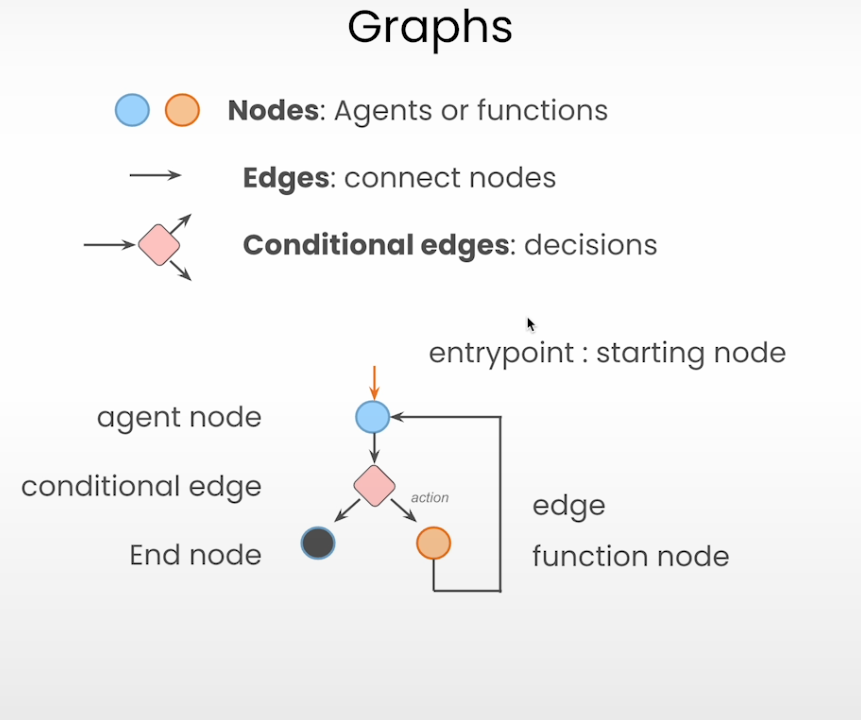


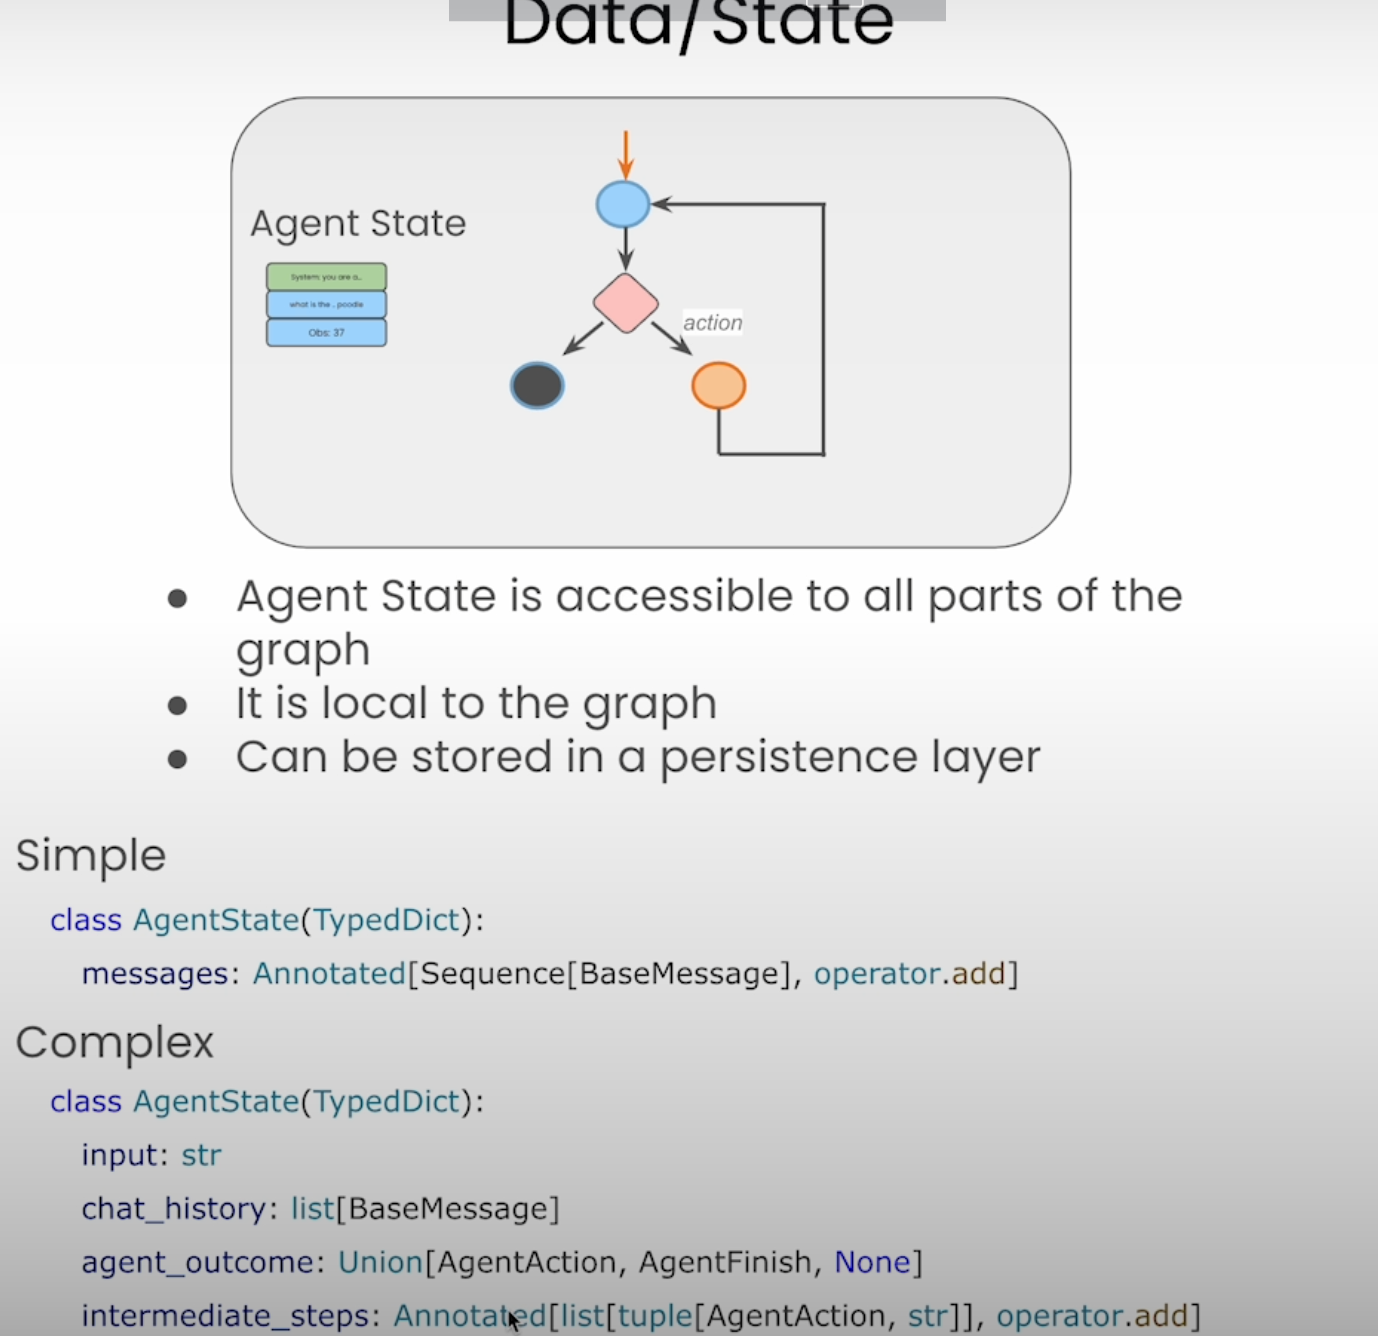

In [12]:
import getpass
import os
# os.environ.get("TAVILY_API_KEY")

In [13]:
from langgraph.graph import StateGraph , END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults


In [14]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [15]:
tool = TavilySearchResults(max_results=2)
print (type(tool))
print (tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [16]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [20]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system=system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action",self.take_action)
        graph.add_conditional_edges(
            "llm", 
            self.exists_action,
            {True: "action", False:END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
    
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls)>0
    
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print (f'Calling: {t}')
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print ("Back to the model")
        return {'messages': results}

In [21]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [22]:
model = ChatOpenAI(model='gpt-3.5-turbo')
abot = Agent(model, [tool], system=prompt)

In [27]:
# from IPython.display import Image
# Image(abot.graph.get_graph().draw_png())

In [29]:
messages = [HumanMessage(content="What is the weather in Portland, Oregon?")]
result = abot.graph.invoke({"messages":messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Portland, Oregon'}, 'id': 'call_zsk2gi2tPEvTEoJ4dueXgF0f', 'type': 'tool_call'}
Back to the model


In [30]:
result

{'messages': [HumanMessage(content='What is the weather in Portland, Oregon?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zsk2gi2tPEvTEoJ4dueXgF0f', 'function': {'arguments': '{"query":"weather in Portland, Oregon"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 155, 'total_tokens': 178, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d8e5dd2f-418f-49b3-bdf4-2c488f9e6eba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Portland, Oregon'}, 'id': 'call_zsk2gi2tPEvTEoJ4dueXgF0f', 'type': 'tool_call

In [31]:
result['messages'][-1].content

'The current weather in Portland, Oregon is as follows:\n- Temperature: 45.0°F (7.2°C)\n- Condition: Heavy rain\n- Wind: 4.7 mph (WNW)\n- Pressure: 29.39 in\n- Humidity: 86%\n- Cloud Cover: 100%\n- Visibility: 2.0 miles\n- More details can be found at [Weather in Portland, Oregon](https://www.weatherapi.com/)'

In [34]:
messages = [HumanMessage(content="What is the weather in Portland, Oregon and Chennai, India?")]
            
result = abot.graph.invoke({"messages":messages})
result['messages'][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Portland, Oregon'}, 'id': 'call_LwZMk9ok53czkJQdGaECEnkP', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Chennai, India'}, 'id': 'call_hNOMVC4G6klrHC9aOjVG78aX', 'type': 'tool_call'}
Back to the model


'The current weather in Portland, Oregon is 45.0°F with heavy rain. The wind speed is 7.6 kph coming from the WNW direction. The humidity is at 86%.\n\nIn Chennai, India, the current temperature is 89.8°F with partly cloudy skies. The wind speed is 10.1 kph coming from the ESE direction. The humidity in Chennai is at 71%.'

In [37]:
query = "which country won the cricket champions trophy 2025 and who scored the most runs from the team that won the trophy?"
messages = [HumanMessage(content=query)]
result = abot.graph.invoke({"messages":messages})
result['messages'][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Cricket Champions Trophy 2025 winner'}, 'id': 'call_O3JmkJ0yuU17lVh4TjAtQgYQ', 'type': 'tool_call'}
Back to the model
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Leading run scorer in 2025 ICC Champions Trophy from India team'}, 'id': 'call_Ns0r6kJ2LfnEkCiSRlijGuuQ', 'type': 'tool_call'}
Back to the model


'- The country that won the Cricket Champions Trophy 2025 is India. They beat New Zealand by four wickets in the final.\n- The player who scored the most runs from the India team in the 2025 ICC Champions Trophy was Virat Kohli, with 217 runs over four matches.'